Here we will implement a neural network using Keras to predict stock returns. 

In [95]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

train_set shape
(1918,)
test_set shape
(480,)
Xtrain shape
(1858, 60, 1)
Epoch 1/10
59/59 [==============================] - 66s 895ms/step - loss: 0.1284
Epoch 2/10
59/59 [==============================] - 57s 972ms/step - loss: 0.0222
Epoch 3/10
59/59 [==============================] - 57s 971ms/step - loss: 0.0149
Epoch 4/10
59/59 [==============================] - 53s 895ms/step - loss: 0.0116
Epoch 5/10
59/59 [==============================] - 61s 1s/step - loss: 0.0080
Epoch 6/10
59/59 [==============================] - 58s 985ms/step - loss: 0.0073
Epoch 7/10
59/59 [==============================] - 63s 1s/step - loss: 0.0058
Epoch 8/10
59/59 [==============================] - 60s 1s/step - loss: 0.0056
Epoch 9/10
59/59 [==============================] - 57s 968ms/step - loss: 0.0053
Epoch 10/10
59/59 [==============================] - 59s 997ms/step - loss: 0.0046
total data shape
(2398,)
Xtest shape
(480, 60, 1)
model data shape
(2338, 60, 1)
graph points


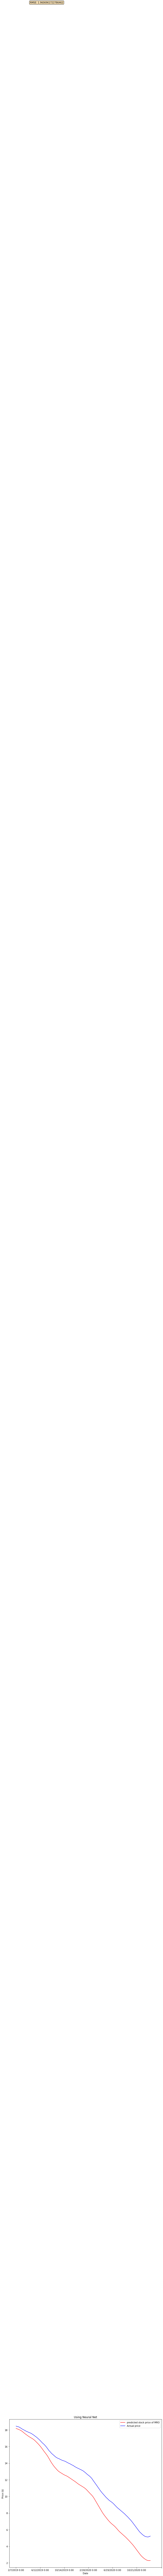

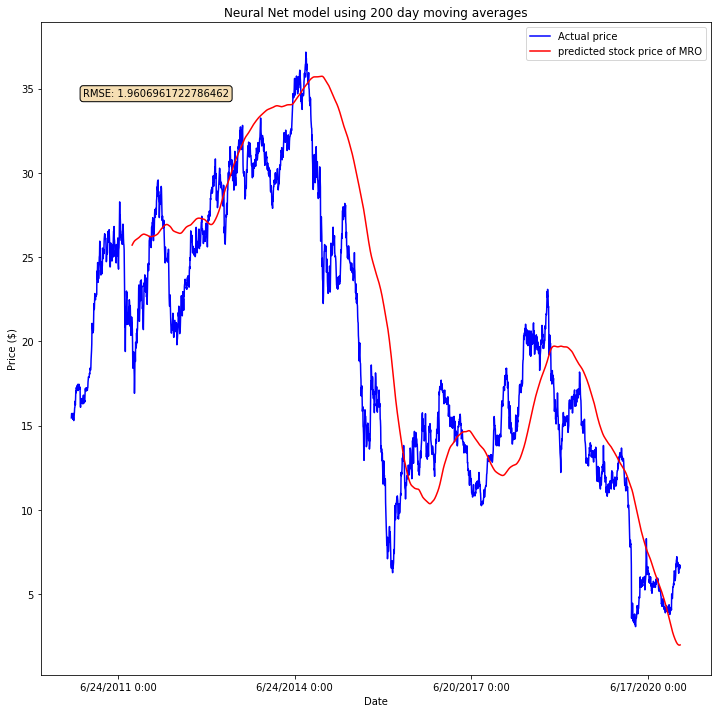

In [94]:
def nn_5day_ret(stock, ma):
    #gathering data
    df = pd.read_csv('moving_average_plus_returns.csv')
    dates = df['Date']
    stock_prices = df[stock]
    stock_prices = np.array(stock_prices)
    moving_avg = df[stock + '_' + ma +'day_MA']
    moving_avg = np.array(moving_avg)
    moving_avg = moving_avg[199:]
    train_test_split = int(moving_avg.shape[0] * 0.8)
    train_set = moving_avg[0:train_test_split]
    test_set = moving_avg[train_test_split:]
    #end of gathering data
    print("train_set shape")
    print(train_set.shape)
    print("test_set shape")
    print(test_set.shape)

    #feature scaling
    sc = MinMaxScaler(feature_range = (0,1))
    train_set_scaled = sc.fit_transform(np.reshape(train_set, (-1,1))) #we could maybe try using the moving averages?
    X_train, y_train = [], []
    for i in range(60, train_set.shape[0]):
        X_train.append(train_set_scaled[i-60:i, 0])
        y_train.append(train_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print("Xtrain shape")
    print(X_train.shape)

    #building NN model
    model = Sequential()
    model.add(LSTM(256,return_sequences=True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse')
    s = tf.keras.backend.clear_session()
    #done building NN
    model.fit(X_train, y_train, batch_size=32, epochs=10)

    #prepared testing data
    total_data = np.concatenate((train_set, test_set))
    print("total data shape")
    print(total_data.shape)
    inputs = total_data[len(total_data) - len(test_set) -60: ]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    X_test = []
    y_test = []
    for i in range(60, inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    print("Xtest shape")
    print(X_test.shape)
    yhat = model.predict(X_test)
    yhat = sc.inverse_transform(yhat)
    rmse = mean_squared_error(yhat, test_set, squared=False)

    #generating NN model
    total_set_scaled = sc.fit_transform(np.reshape(total_data, (-1,1)))
    model_data = []
    for i in range(60,total_data.shape[0]):
        model_data.append(total_set_scaled[i-60:i, 0]) ##Convert back to [i-60:i,0]
    model_data = np.array(model_data)
    model_data = np.reshape(model_data, (model_data.shape[0], model_data.shape[1], 1))
    print("model data shape")
    print(model_data.shape)
    model_graph = model.predict(model_data)
    model_graph = sc.inverse_transform(model_graph)
    print("graph points")

    #Visualising the results
    fig1, axes1 = plt.subplots(1,1)
    axes1.plot(dates, stock_prices, color ="blue")
    axes1.plot(dates[199 + 60:], model_graph, color="red")
    axes1.set_title("Neural Net model using {} day moving averages".format(ma))
    axes1.legend(["Actual price", "predicted stock price of " + stock])
    axes1.xaxis.set_label_text("Date")
    axes1.yaxis.set_label_text("Price ($)")
    props = dict(boxstyle='round', facecolor='wheat')
    axes1.text(50, 35, "RMSE: {}".format(rmse), bbox = props, verticalalignment = 'top')
    axes1.set_xticks([200, 953, 1706, 2459]) #adjusts the number of ticks (dates displayed on x axis)
    fig1.set_figheight(12)
    fig1.set_figwidth(12)
    
    





nn_5day_ret('MRO', '200') #pass in 10, 50, or 200 as a string for ma
